In [6]:
import attacker
from typing import *
from sklearn.feature_selection import mutual_info_regression

In [2]:
def f(age : List[float]) -> float:
    return sum(age)/len(age)

In [3]:
def q(trace):
    I = mutual_info_regression(trace["Alice_age"][:,0].reshape(-1,1), trace["out"][:,0])[0]
    return -I

In [4]:
domain = [
    {
        "name": "age",
        "lower": 10,
        "upper": 80,
        "type": "float"
    },
]

In [5]:
res = attacker.construct_analysis(f, domain, q)

====================##] - 60/60 - Time left: 00:00:00 
Value of (x,y) that minimises the objective:[  3.          13.54229831 232.99222682]
Minimum value of the objective: -4.585773110008709


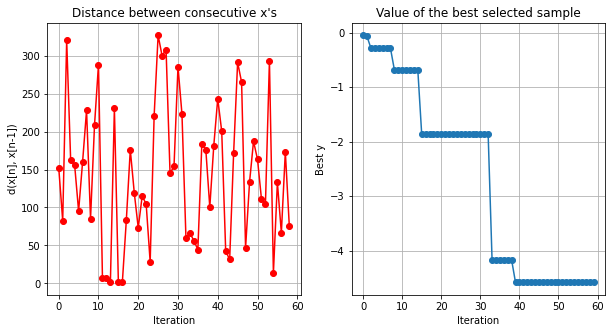

In [6]:
res.plot_convergence()

In [7]:
res.run()

There were 9510 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9455 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


-4.585773110008709

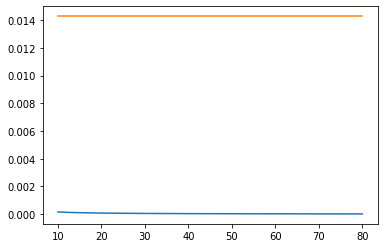

In [18]:
x = np.linspace(10,80,1000)
y = np.exp(pm.Gamma.dist(mu=13.059, sigma=322.852).logp(x).eval())
y2 = np.exp(pm.Uniform.dist(10, 80).logp(x).eval())
plt.plot(x,y)
plt.plot(x,y2)

# Open DB

In [14]:
import numpy as np
import pandas as pd
import opendp.smartnoise.core as sn
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import theano
from sklearn.feature_selection import mutual_info_regression
from typing import List

def wrapper(a: List[int], s: List[int], e: List[int], r: List[int], i : List[float], m: List[int]) -> float:
    ## opendp program
    @theano.compile.ops.as_op(itypes=[tt.lvector,tt.lvector,tt.lvector,
                                      tt.lvector,tt.dvector,tt.lvector],
                              otypes=[tt.dscalar])
    def dp_program(age,sex,educ,race,income,married):
        temp_file='temp.csv'    
        var_names = ["age", "sex", "educ", "race", "income", "married"]
        data = {
            "age":     age,
            "sex":     sex,
            "educ":    educ,
            "race":    race,
            "income":  income,
            "married": married
        }
        df = pd.DataFrame(data,columns=var_names)
        df.to_csv(temp_file)
        with sn.Analysis() as analysis:
            # load data
            data = sn.Dataset(path=temp_file,column_names=var_names)

            # get mean of age
            age_mean = sn.dp_mean(data = sn.to_float(data['income']),
                                  privacy_usage = {'epsilon': .1},
                                  data_lower = 0., # min income
                                  data_upper = 200., # max income                   
                                  data_rows = 10
                                 )
        analysis.release()
        return np.float64(age_mean.value)    
    return dp_program(a,s,e,r,i,m)

In [9]:
domain = [
    {
        "name": "age",
        "lower": 10,
        "upper": 80,
        "type": "int"
    },
    {
        "name": "sex",
        "lower": 0,
        "upper": 2,
        "type": "int"
    },
    {
        "name": "educ",
        "lower": 0,
        "upper": 10,
        "type": "int"
    },
    {
        "name": "race",
        "lower": 0,
        "upper": 50,
        "type": "int"
    },
    {
        "name": "income",
        "lower": 0,
        "upper": 200,
        "type": "float"
    },
    {
        "name": "married",
        "lower": 0,
        "upper": 1,
        "type": "int"
    },
]

In [10]:
def q(trace):
    I = mutual_info_regression(trace["Alice_income"][:,0].reshape(-1,1), trace["out"][:,0])[0]
    return -I

In [13]:
res = attacker.construct_analysis(wrapper, domain, q)

AttributeError: 'numpy.ndarray' object has no attribute 'type'